In [15]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import warnings
import gcsfs
from xhistogram.xarray import histogram
import intake
import util
import gsw
import dask
import netCDF4
import pandas as pd
nm = 12

In [2]:
url = "https://raw.githubusercontent.com/andrewpauling/cmip6hack-so-project/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)

In [20]:
cat = col.search(experiment_id=['historical'], institution_id=['BCC','NCAR'], table_id=['SImon','Omon'], member_id='r1i1p1f1', variable_id=['thetao','so','siconc'], grid_label='gn')
cat.df

activity_id institution_id    source_id experiment_id member_id  \
323          CMIP            BCC  BCC-CSM2-MR    historical  r1i1p1f1   
325          CMIP            BCC  BCC-CSM2-MR    historical  r1i1p1f1   
586          CMIP            BCC     BCC-ESM1    historical  r1i1p1f1   
588          CMIP            BCC     BCC-ESM1    historical  r1i1p1f1   
13446        CMIP           NCAR  CESM2-WACCM    historical  r1i1p1f1   
14574        CMIP           NCAR        CESM2    historical  r1i1p1f1   
14580        CMIP           NCAR        CESM2    historical  r1i1p1f1   
14633        CMIP           NCAR        CESM2    historical  r1i1p1f1   

      table_id variable_id grid_label  \
323       Omon          so         gn   
325       Omon      thetao         gn   
586       Omon          so         gn   
588       Omon      thetao         gn   
13446    SImon      siconc         gn   
14574     Omon          so         gn   
14580     Omon      thetao         gn   
14633    SImon      siconc         gn   

                                                  zstore  dcpp_init_year  
323    gs://cmip6/CMIP/BCC/BCC-CSM2-MR/historical/r1i...             NaN  
325    gs://cmip6/CMIP/BCC/BCC-CSM2-MR/historical/r1i...             NaN  
586    gs://cmip6/CMIP/BCC/BCC-ESM1/historical/r1i1p1...             NaN  
588    gs://cmip6/CMIP/BCC/BCC-ESM1/historical/r1i1p1...             NaN  
13446  gs://cmip6/CMIP/NCAR/CESM2-WACCM/historical/r1...             NaN  
14574  gs://cmip6/CMIP/NCAR/CESM2/historical/r1i1p1f1...             NaN  
14580  gs://cmip6/CMIP/NCAR/CESM2/historical/r1i1p1f1...             NaN  
14633  gs://cmip6/CMIP/NCAR/CESM2/historical/r1i1p1f1...             NaN

In [17]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': False})
dset_dict.keys()

dict_keys(['CMIP.BCC.BCC-CSM2-MR.historical.Omon.gn', 'CMIP.BCC.BCC-ESM1.historical.Omon.gn', 'CMIP.NCAR.CESM2.historical.Omon.gn'])

In [23]:
ds = dset_dict['CMIP.BCC.BCC-ESM1.historical.Omon.gn']

In [28]:
A = ds.sel(time=slice("1980","2000")).groupby("time.month").mean()
A.sel(month=7)

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 232, lev: 40, lon: 360, member_id: 1)
Coordinates:
  * lev        (lev) float64 5.0 15.0 25.0 ... 4.289e+03 4.807e+03 5.334e+03
  * member_id  (member_id) <U8 'r1i1p1f1'
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 -81.5 -80.5 -79.5 -78.5 ... 86.5 87.5 88.5 89.5
    month      int64 7
Dimensions without coordinates: bnds
Data variables:
    latitude   (lat, lon) float32 dask.array<chunksize=(232, 360), meta=np.ndarray>
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(40, 2), meta=np.ndarray>
    longitude  (lat, lon) float32 dask.array<chunksize=(232, 360), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(232, 2), meta=np.ndarray>
    so         (member_id, lev, lat, lon) float32 dask.array<chunksize=(1, 40, 232, 360), meta=np.ndarray>
    thetao     (member_id, lev

In [ ]:
A.sel

In [16]:
pd.to_datetime(ds.time[0])

ValueError: Buffer has wrong number of dimensions (expected 1, got 0)

In [28]:
dates = netCDF4.num2date(ds.time, ds.time.units)

In [29]:
dates[0]

real_datetime(1848, 10, 22, 13, 0)

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


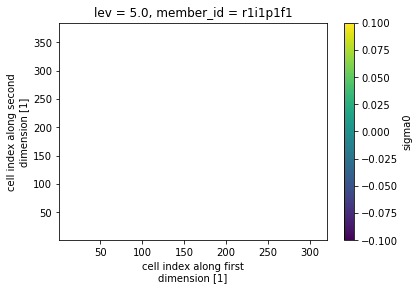

In [27]:
def calc_mld(ds):
    # getting time slice and selecting Augusts
    ds = ds.isel(time=slice((1986-1850)*nm,(2006-1850)*nm))
    ds = ds.isel(time=np.arange(7,20*nm,nm)).mean(dim='time')
    
    # Make depth/lev coordinate uniform in name
    if 'depth' in ds:
        ds.depth = xr.Dataset.rename({'depth':'lev'})
    
    # and units
    if ds.lev.units == 'centimeters':
        ds.lev.values = ds.lev.values/100
    
    # calculate potential density using gibbs sea water package
    cthetao = xr.apply_ufunc(gsw.CT_from_pt, ds.so, ds.thetao, dask='parallelized',
                                             output_dtypes=[float,]).rename('cthetao').to_dataset() 
    ds = xr.merge([cthetao, ds])
    
    # using sigma0 here to calculate mixed layer depth
    sigma0=xr.apply_ufunc(gsw.density.sigma0,ds.so, ds.cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('sigma0').to_dataset()
    ds = xr.merge([sigma0, ds])
  
    # Interpolate potential density
    dsi = ds.sigma0.interp(lev=np.linspace(0,20,21))
    surf_dens = dsi.sel(lev = 10)
    
    ds.sigma0.isel(lev=0).plot()
    
    # calculate sigma2
    sigma2=xr.apply_ufunc(gsw.density.sigma2,ds.so, ds.cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('sigma2').to_dataset()
    ds = xr.merge([sigma2, ds])
    
    # Calculate mixed layer depth based on density difference from 10m
    dens_diff = ds.sigma0 - surf_dens
    dens_diff = dens_diff.where(dens_diff > 0.03)
    mld = dens_diff.lev.where(dens_diff==dens_diff.min(['lev'])).max(['lev'])
    
    #dens_diff.isel(lev=0).plot()

    return ds


for i in dset_dict:
     newds = calc_mld(dset_dict[i])   

In [ ]:
    # add mld to dataset
    ds['mld'] = mld
    
    # find depth of bottom
    test = ds.sigma0 + ds.lev
    print(test)
    bottom_depth = ds.lev.where(test == test.max(dim='lev')).max(dim='lev')
    bottom_depth.plot()
    #add to dataset
    ds['bottom_depth'] = bottom_depth
    ds['relative_depth'] = mld/bottom_depth
        
    # find bottom potential density referenced to 2000m and temperature
    bottom_sigma2 = ds.sigma2.where(test == test.max(['lev'])).max(dim='lev')
    print(bottom_sigma2)
    ds['bottom_sigma2'] = bottom_sigma2
    
    bottom_temp = ds.thetao.where(test == test.max(['lev'])).max(dim='lev')
    ds['bottom_temp'] = bottom_temp
    
    print(ds)
    return ds

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


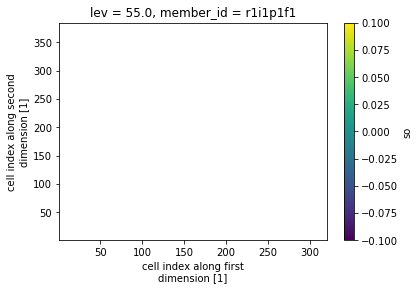

In [29]:
# for i in dset_dict:
#      newds = calc_mld(dset_dict[i]) 
        
newds.so.isel(lev=5).plot()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


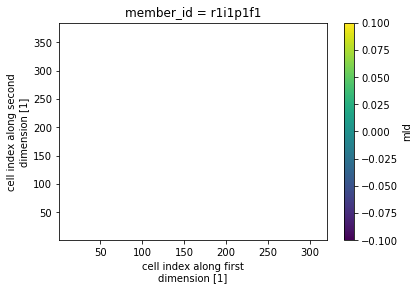

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


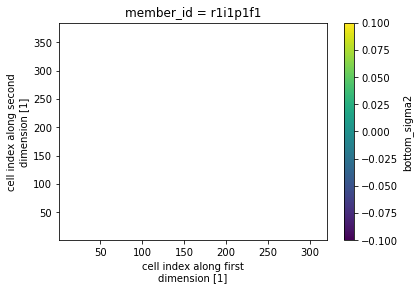

In [8]:
for i in dset_dict:
    dens_diff = dset_dict[i].sigma0 - surf_dens
#     print(dens_diff.isel(time=0).min().values)
    dens_diff = dens_diff.where(dens_diff > 0.03)
#     print(dens_diff.shape)
    mld = dens_diff.lev.where(dens_diff==dens_diff.min(['lev'])).max(['lev'])

AttributeError: 'Dataset' object has no attribute 'sigma0'

In [ ]:
# Mixed layer depth threshold 